### Import

In [1]:
import copy

from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary
from transformers import ViTModel, AutoImageProcessor, BertModel, AutoTokenizer

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

from architecture import Transformer

import cv2

device = torch.device("cuda")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 100
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "nlp": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
    "img_cols": ["img_path"],
    "nlp_cols": []
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
patch_size = 16

d_model = {"encoder":256, "decoder":128}
d_ff = {"encoder":256, "decoder":128}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target": 0.25, "temporal":0.25, "img":0.25, "nlp":0.25}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_train = df_train[~pd.isna(df_train["detail_desc"])]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]
df_valid = df_valid[~pd.isna(df_valid["detail_desc"])]

data_info = DataInfo(modality_info, processing_info)

In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:00<00:00, 29965.65it/s]


sales torch.Size([32, 100, 1])
sales_remain_idx torch.Size([32, 25])
sales_masked_idx torch.Size([32, 75])
sales_revert_idx torch.Size([32, 100])
sales_remain_padding_mask torch.Size([32, 25])
sales_masked_padding_mask torch.Size([32, 75])
sales_revert_padding_mask torch.Size([32, 100])
day torch.Size([32, 100])
day_remain_idx torch.Size([32, 25])
day_masked_idx torch.Size([32, 75])
day_revert_idx torch.Size([32, 100])
day_remain_padding_mask torch.Size([32, 25])
day_masked_padding_mask torch.Size([32, 75])
day_revert_padding_mask torch.Size([32, 100])
dow torch.Size([32, 100])
dow_remain_idx torch.Size([32, 25])
dow_masked_idx torch.Size([32, 75])
dow_revert_idx torch.Size([32, 100])
dow_remain_padding_mask torch.Size([32, 25])
dow_masked_padding_mask torch.Size([32, 75])
dow_revert_padding_mask torch.Size([32, 100])
month torch.Size([32, 100])
month_remain_idx torch.Size([32, 25])
month_masked_idx torch.Size([32, 75])
month_revert_idx torch.Size([32, 100])
month_remain_padding_mask t

# Architecture

In [6]:
model = Transformer(data_info, train_dataset.label_encoder_dict, patch_size,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

---------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                          Output Shape         Param #     Tr. Param #
     Transformer          Encoder-1     [32, 206, 256], [32, 4, 206, 206]         791,552         791,552
     Transformer           Linear-2                        [32, 206, 128]          32,896          32,896
     Transformer            Split-3                                                     0               0
Total params: 824,448
Trainable params: 824,448
Non-trainable params: 0
---------------------------------------------------------------------------------------------------------


'---------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                          Output Shape         Param #     Tr. Param #\n=========================================================================================================\n     Transformer          Encoder-1     [32, 206, 256], [32, 4, 206, 206]         791,552         791,552\n     Transformer           Linear-2                        [32, 206, 128]          32,896          32,896\n     Transformer            Split-3                                                     0               0\n=========================================================================================================\nTotal params: 824,448\nTrainable params: 824,448\nNon-trainable params: 0\n---------------------------------------------------------------------------------------------------------'

# Train

In [7]:
# for name, param in model.named_parameters():
#     if "img_model" in name:
#         param.requires_grad = False
#     elif "nlp_model" in name:
#         param.requires_grad = False

In [8]:
import warnings
warnings.filterwarnings("ignore")

def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


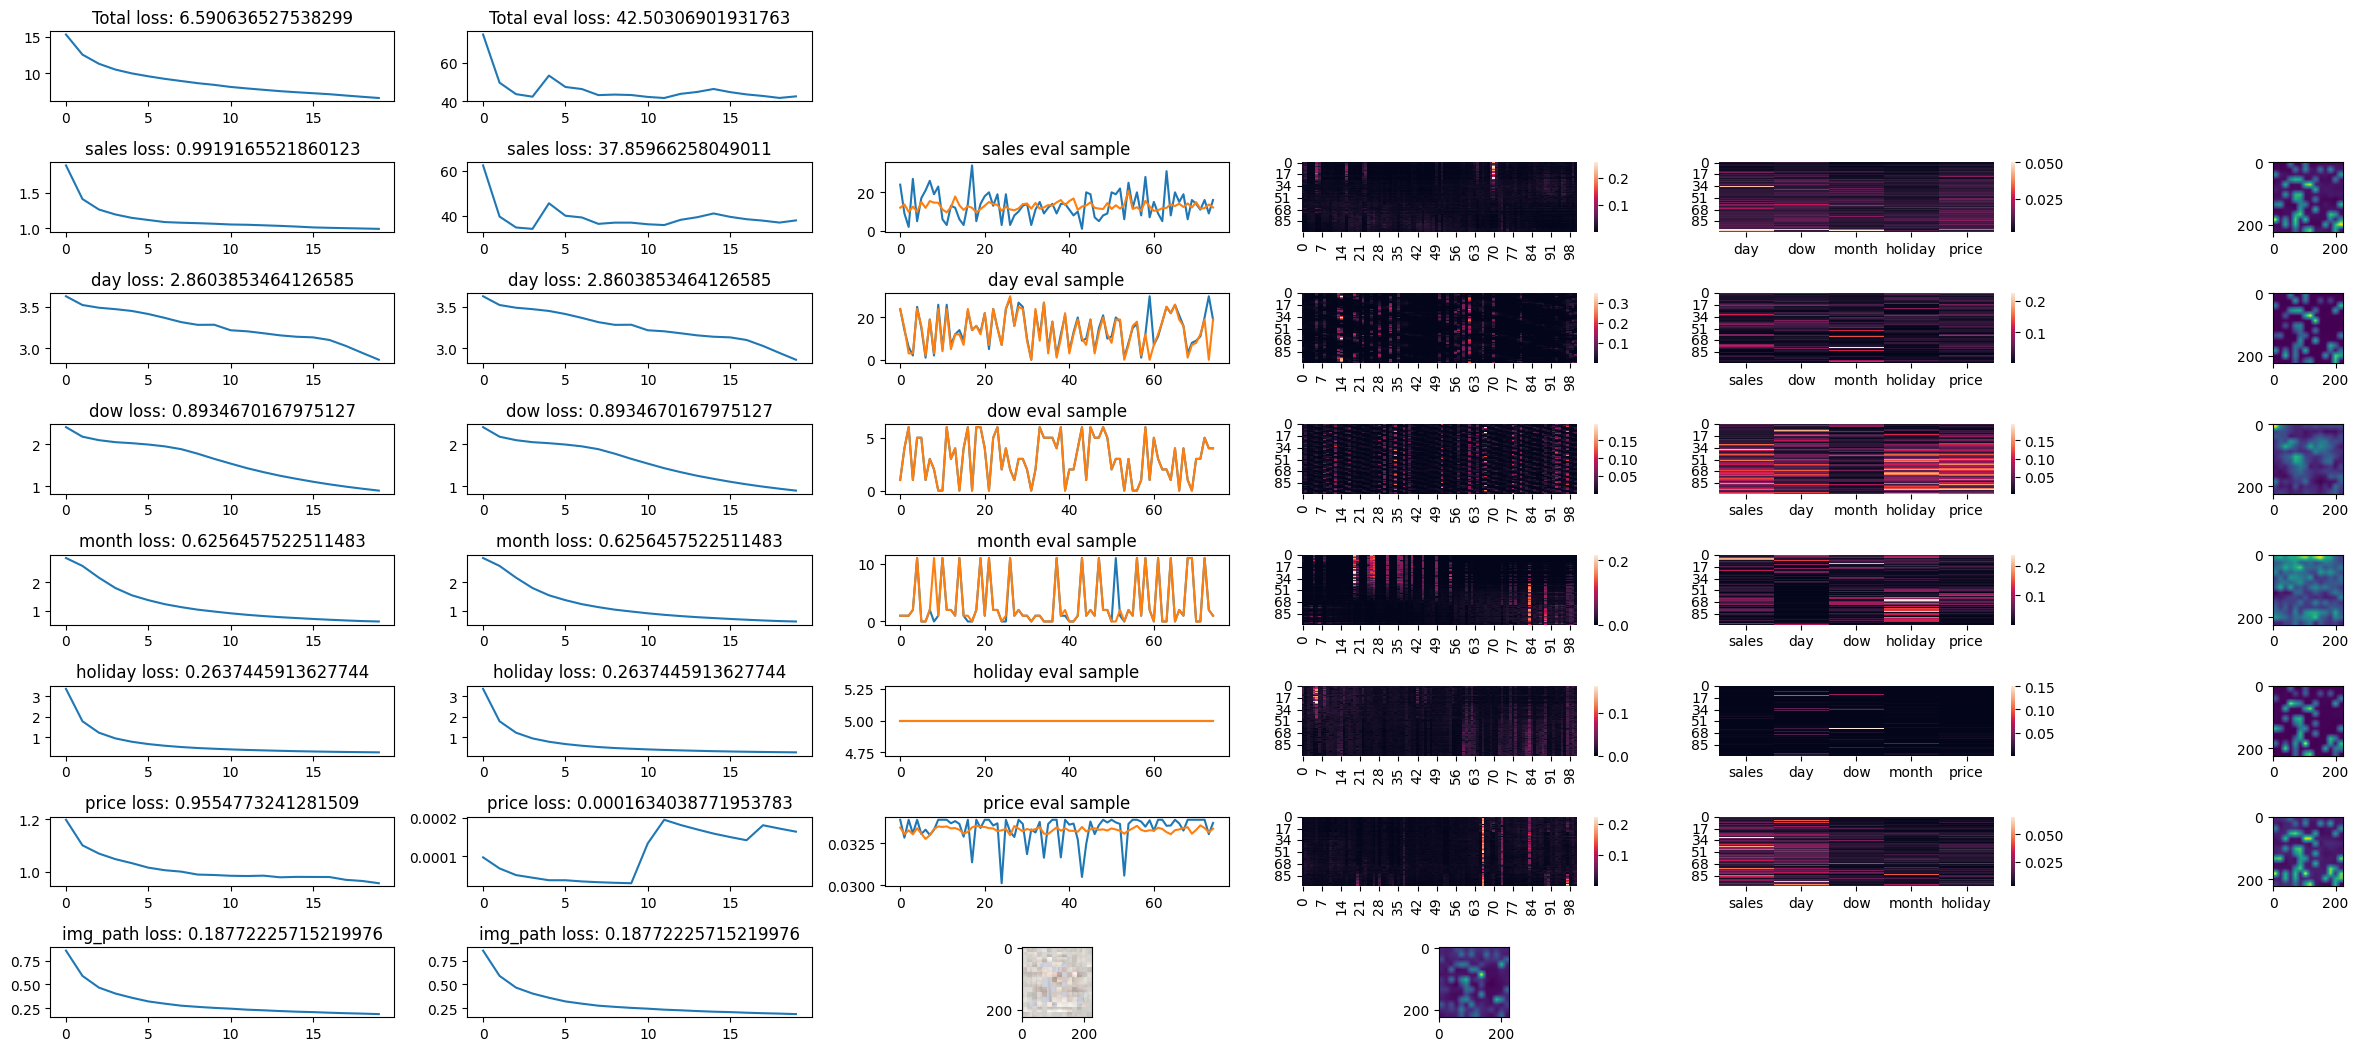

 43%|████▎     | 392/915 [04:33<04:14,  2.05it/s]

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=False):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in temporal_output.items():
        pred = val.squeeze()[:, 1:]
        y = data[key].to(device).squeeze()

        if inverse_scale and key in data_info.processing_info["scaling_cols"]:
            pred = pred.detach().cpu()
            y = y.detach().cpu()

            new_pred, new_y = [], []
            scaler = data[f"{key}_scaler"]

            for i, s in enumerate(scaler):
                new_pred.append(torch.from_numpy(s.inverse_transform(pred[i].reshape(-1,1).numpy())))
                new_y.append(torch.from_numpy(s.inverse_transform(y[i].reshape(-1,1).numpy())))
            
            new_pred = torch.stack(new_pred, dim=0).squeeze().to(device)
            new_y = torch.stack(new_y, dim=0).squeeze().to(device)
            
            assert new_pred.shape == pred.shape and new_y.shape == y.shape

            pred, y = new_pred, new_y

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()
        masked_y = torch.gather(y, index=masked_idx, dim=1)

        if key in data_info.processing_info["scaling_cols"]:
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)
            loss = mse_loss(masked_pred, masked_y)
        elif key in data_info.processing_info["embedding_cols"]:
            masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)

            masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
            masked_y = masked_y.reshape(-1).to(torch.long)

            loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)

        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)

    return loss_dict, masked_pred_dict, masked_y_dict

def get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in img_output.items():
        pred = val[:, 1:, :]
        y = patchify(data[key], patch_size).to(device)

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        loss = mse_loss(masked_pred, masked_y).mean()
        loss_dict[key] = loss

        masked_y_dict[key] = masked_y
        masked_pred_dict[key] = masked_pred
        
    return loss_dict, masked_pred_dict, masked_y_dict

def get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in nlp_output.items():
        pred = val.squeeze()[:, 1:, :]
        y = data[key].to(device).squeeze()
        
        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1).to(torch.long)

        loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)
        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        
    return loss_dict, masked_pred_dict, masked_y_dict

def plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict):
    sample_loss = temporal_loss_dict[key].item()
    loss_li_dict[key].append(sample_loss)
    mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())
    plt.plot(mean_loss_li_dict[key])
    plt.title(f"{key} loss: {mean_loss_li_dict[key][-1]}")
    
    return loss_li_dict, mean_loss_li_dict

def plot_temporal(temporal_output, data_info, idx, data,
                    temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                    self_attn_dict, cross_attn_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(temporal_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = eval_temporal_masked_y_dict[key].detach().cpu()
        eval_sample_pred = eval_temporal_masked_pred_dict[key].detach().cpu()
        if key in data_info.processing_info["embedding_cols"]:
            eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)
        plt.plot(eval_sample_y[idx], label="y")
        plt.plot(eval_sample_pred[idx], label="pred")
        plt.title(f"{key} eval sample")
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = self_attn_dict[key][idx].mean(dim=0).detach().cpu()
        sns.heatmap(weight)
        plot_idx += 1

        # Plot cross heatmap
        weight = cross_attn_dict[key][idx].mean(dim=0).squeeze().detach().cpu()

        # Temporal
        plt.subplot(nrows, ncols, plot_idx)
        temporal_weight_dict = {}
        start_idx = 0
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            if col == key: continue
            temporal_weight_dict[col] = weight[:, start_idx:start_idx+1]
            start_idx += 1

        temporal_weight = torch.cat(list(temporal_weight_dict.values()), dim=-1)
        ax = sns.heatmap(temporal_weight)
        ax.set_xticklabels(temporal_weight_dict.keys())
        plot_idx += 1

        # Img
        plt.subplot(nrows, ncols, plot_idx)
        length = (224//patch_size)**2 + 1
        for col in data_info.modality_info["img"]:
            img_weight = weight[:, start_idx:start_idx+length][0, 1:].numpy()
            img_weight = img_weight.reshape(224//patch_size,224//patch_size)
            img_weight = cv2.resize(img_weight / img_weight.max(), data[f"{col}_raw"][idx].size)[..., np.newaxis]
            plt.imshow(img_weight)
            plot_idx += 1
            start_idx += length

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_img(img_output, data_info, idx, data,
                    img_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_img_masked_pred_dict, eval_img_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(img_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, img_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = patchify(data[key], patch_size)[idx]
        eval_sample_pred = eval_img_masked_pred_dict[key].detach().cpu()[idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_y[masked_idx] = eval_sample_pred
        eval_sample_y = unpatchify(eval_sample_y.unsqueeze(0), patch_size)
        eval_sample_y = torch.permute(eval_sample_y.squeeze(), (1,2,0))
        plt.imshow(eval_sample_y)
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = self_attn_dict[key][idx]
        weight = torch.mean(weight, dim=0).squeeze().detach().cpu()
        weight = weight.numpy()
        weight = weight[1:].reshape(224//patch_size,224//patch_size)
        weight = cv2.resize(weight / weight.max(), data[f"{key}_raw"][idx].size)[..., np.newaxis]
        plt.imshow(weight)
        plot_idx += 3

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_nlp(nlp_output, data_info, idx, data,
                    nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(nlp_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, nlp_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot sample
        eval_sample_y = torch.tensor(tokenizer(data[f"{key}_raw"][idx])["input_ids"])
        eval_sample_pred = eval_nlp_masked_pred_dict[key].detach().cpu()
        eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)[idx]
        
        remain_idx = idx_dict[f"{key}_remain_idx"][idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_full = torch.zeros(idx_dict[f"{key}_revert_idx"].shape)[idx].to(torch.int)

        eval_sample_full[masked_idx] = eval_sample_pred.to(torch.int)

        print(tokenizer.decode(eval_sample_y))
        print(tokenizer.decode(eval_sample_full))

        # Plot heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = cross_attn_dict[key][idx]
        weight = weight.squeeze()[:, len(data_info.modality_info["target"]+data_info.modality_info["temporal"])+(14*14+1):]
        ax = sns.heatmap(weight.detach().cpu())

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    eval_loss_li_dict, eval_mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        temporal_output, img_output, nlp_output, self_attn_dict, cross_attn_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)
        
        temporal_loss_dict, temporal_masked_pred_dict, temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info)
        img_loss_dict, img_masked_pred_dict, img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
        nlp_loss_dict, nlp_masked_pred_dict, nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)

        temporal_total_loss = torch.nansum(torch.stack(list(temporal_loss_dict.values())))
        try :
            img_total_loss = torch.nansum(torch.stack(list(img_loss_dict.values())))
        except:
            img_total_loss = torch.tensor([0]).to(device)

        try:
            nlp_total_loss = torch.nansum(torch.stack(list(nlp_loss_dict.values())))
        except: 
            nlp_total_loss = torch.tensor([0]).to(device)
        
        temporal_loss_dict["total"] = temporal_total_loss
        img_loss_dict["total"] = img_total_loss
        nlp_loss_dict["total"] = nlp_total_loss

        loss = temporal_total_loss + img_total_loss + nlp_total_loss
        loss.backward()
        optimizer.step()

        # Eval
        model.eval()
        with torch.no_grad():
            eval_temporal_loss_dict, eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=True)
            eval_img_loss_dict, eval_img_masked_pred_dict, eval_img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
            eval_nlp_loss_dict, eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)
        eval_temporal_loss = torch.nansum(torch.stack(list(eval_temporal_loss_dict.values())))
        try:
            eval_img_loss = torch.nansum(torch.stack(list(eval_img_loss_dict.values())))
        except: 
            eval_img_loss = torch.tensor([0]).to(device)
        
        try:
            eval_nlp_loss = torch.nansum(torch.stack(list(eval_nlp_loss_dict.values())))
        except:
            eval_nlp_loss = torch.tensor([0]).to(device)
        
        eval_temporal_loss_dict["total"] = eval_temporal_loss
        eval_img_loss_dict["total"] = eval_img_loss
        eval_nlp_loss_dict["total"] = eval_nlp_loss

        # Plot
        if n % 20 == 0:
            plt.figure(figsize=(25,13))
            clear_output(wait=True)
            nrows, ncols = 10, 6

            # Plot total loss
            plt.subplot(nrows, ncols, 1)
            total_loss = temporal_loss_dict["total"].item()
            loss_li_dict["total"].append(total_loss)
            mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())
            plt.plot(mean_loss_li_dict["total"])
            plt.title(f'Total loss: {mean_loss_li_dict["total"][-1]}')

            # Plot eval total loss
            plt.subplot(nrows, ncols, 2)
            eval_total_loss = eval_temporal_loss_dict["total"].item()
            eval_loss_li_dict["total"].append(eval_total_loss)
            eval_mean_loss_li_dict["total"].append(np.array(eval_loss_li_dict["total"]).mean())
            plt.plot(eval_mean_loss_li_dict["total"])
            plt.title(f'Total eval loss: {eval_mean_loss_li_dict["total"][-1]}')

            # Plot sample
            plot_idx = 7
            idx = 0
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_temporal(temporal_output, data_info, idx, data,
                                                                            temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict,
                                                                            nrows, ncols, plot_idx)
            
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_img(img_output, data_info, idx, data,
                                                                            img_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_img_masked_pred_dict, eval_img_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict, idx_dict,
                                                                            nrows, ncols, plot_idx)

            loss_li_dict, mean_loss_li_dict,\
                            eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_nlp(nlp_output, data_info, idx, data,
                                                                                        nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                                        eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                                        eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                                                                                        self_attn_dict, cross_attn_dict, idx_dict,
                                                                                        nrows, ncols, plot_idx)

            plt.tight_layout()
            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise

In [ ]:
raise
path = "./saved_model_240414_1734"
torch.save(model.state_dict(), path)

In [ ]:
path = "./saved_model_240414_1734"

In [ ]:
model_load = Transformer(data_info, train_dataset.label_encoder_dict, patch_size,
                        d_model, num_layers, nhead, d_ff, dropout, "gelu")

model_load.load_state_dict(torch.load(path))
model_load.to(device)
_  = ""

# model_load.eval()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=False):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in temporal_output.items():
        pred = val.squeeze()[:, 1:]
        y = data[key].to(device).squeeze()

        if inverse_scale and key in data_info.processing_info["scaling_cols"]:
            pred = pred.detach().cpu()
            y = y.detach().cpu()

            new_pred, new_y = [], []
            scaler = data[f"{key}_scaler"]

            for i, s in enumerate(scaler):
                new_pred.append(torch.from_numpy(s.inverse_transform(pred[i].reshape(-1,1).numpy())))
                new_y.append(torch.from_numpy(s.inverse_transform(y[i].reshape(-1,1).numpy())))
            
            new_pred = torch.stack(new_pred, dim=0).squeeze().to(device)
            new_y = torch.stack(new_y, dim=0).squeeze().to(device)
            
            assert new_pred.shape == pred.shape and new_y.shape == y.shape

            pred, y = new_pred, new_y

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()
        masked_y = torch.gather(y, index=masked_idx, dim=1)

        if key in data_info.processing_info["scaling_cols"]:
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)
            loss = mse_loss(masked_pred, masked_y)
        elif key in data_info.processing_info["embedding_cols"]:
            masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
            masked_pred = torch.gather(pred, index=masked_idx, dim=1)

            masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
            masked_y = masked_y.reshape(-1).to(torch.long)

            loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)

        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)

    return loss_dict, masked_pred_dict, masked_y_dict

def get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in img_output.items():
        pred = val[:, 1:, :]
        y = patchify(data[key], patch_size).to(device)

        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        loss = mse_loss(masked_pred, masked_y).mean()
        loss_dict[key] = loss

        masked_y_dict[key] = masked_y
        masked_pred_dict[key] = masked_pred
        
    return loss_dict, masked_pred_dict, masked_y_dict

def get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info):
    loss_dict, masked_pred_dict, masked_y_dict = {}, {}, {}
    for key, val in nlp_output.items():
        pred = val.squeeze()[:, 1:, :]
        y = data[key].to(device).squeeze()
        
        masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
        padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()

        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1).to(torch.long)

        loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)
        loss = loss * padding_mask
        loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
        loss_dict[key] = loss

        masked_pred_dict[key] = masked_pred.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        masked_y_dict[key] = masked_y.reshape(padding_mask.shape[0], padding_mask.shape[1], -1)
        
    return loss_dict, masked_pred_dict, masked_y_dict

def plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict):
    sample_loss = temporal_loss_dict[key].item()
    loss_li_dict[key].append(sample_loss)
    mean_loss_li_dict[key].append(np.array(loss_li_dict[key]).mean())
    plt.plot(mean_loss_li_dict[key])
    plt.title(f"{key} loss: {mean_loss_li_dict[key][-1]}")
    
    return loss_li_dict, mean_loss_li_dict

def plot_temporal(temporal_output, data_info, idx, data,
                    temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                    self_attn_dict, cross_attn_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(temporal_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, temporal_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = eval_temporal_masked_y_dict[key].detach().cpu()
        eval_sample_pred = eval_temporal_masked_pred_dict[key].detach().cpu()
        if key in data_info.processing_info["embedding_cols"]:
            eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)
        plt.plot(eval_sample_y[idx], label="y")
        plt.plot(eval_sample_pred[idx], label="pred")
        plt.title(f"{key} eval sample")
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = self_attn_dict[key][idx].mean(dim=0).detach().cpu()
        sns.heatmap(weight)
        plot_idx += 1

        # Plot cross heatmap
        weight = cross_attn_dict[key][idx].mean(dim=0).squeeze().detach().cpu()

        # Temporal
        plt.subplot(nrows, ncols, plot_idx)
        temporal_weight_dict = {}
        start_idx = 0
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            if col == key: continue
            temporal_weight_dict[col] = weight[:, start_idx:start_idx+1]
            start_idx += 1

        temporal_weight = torch.cat(list(temporal_weight_dict.values()), dim=-1)
        ax = sns.heatmap(temporal_weight)
        ax.set_xticklabels(temporal_weight_dict.keys())
        plot_idx += 1

        # Img
        plt.subplot(nrows, ncols, plot_idx)
        length = (224//patch_size)**2 + 1
        for col in data_info.modality_info["img"]:
            img_weight = weight[:, start_idx:start_idx+length][0, 1:].numpy()
            img_weight = img_weight.reshape(224//patch_size,224//patch_size)
            img_weight = cv2.resize(img_weight / img_weight.max(), data[f"{col}_raw"][idx].size)[..., np.newaxis]
            plt.imshow(img_weight)
            plot_idx += 1
            start_idx += length

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_img(img_output, data_info, idx, data,
                    img_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_img_masked_pred_dict, eval_img_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(img_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, img_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot eval sample
        plt.subplot(nrows, ncols, plot_idx)
        eval_sample_y = patchify(data[key], patch_size)[idx]
        eval_sample_pred = eval_img_masked_pred_dict[key].detach().cpu()[idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_y[masked_idx] = eval_sample_pred
        eval_sample_y = unpatchify(eval_sample_y.unsqueeze(0), patch_size)
        eval_sample_y = torch.permute(eval_sample_y.squeeze(), (1,2,0))
        plt.imshow(eval_sample_y)
        plot_idx += 1

        # Plot self heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = self_attn_dict[key][idx]
        weight = torch.mean(weight, dim=0).squeeze().detach().cpu()
        weight = weight.numpy()
        weight = weight[1:].reshape(224//patch_size,224//patch_size)
        weight = cv2.resize(weight / weight.max(), data[f"{key}_raw"][idx].size)[..., np.newaxis]
        plt.imshow(weight)
        plot_idx += 3

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def plot_nlp(nlp_output, data_info, idx, data,
                    nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                    eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                    eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                    self_attn_dict, cross_attn_dict, idx_dict,
                    nrows, ncols, plot_idx):
    for n, (key, val) in enumerate(nlp_output.items()):
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, nlp_loss_dict, loss_li_dict, mean_loss_li_dict)
        plot_idx += 1

        # Plot eval loss
        plt.subplot(nrows, ncols, plot_idx)
        plot_loss(key, eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict)
        plot_idx += 1

        # Plot sample
        eval_sample_y = torch.tensor(tokenizer(data[f"{key}_raw"][idx])["input_ids"])
        eval_sample_pred = eval_nlp_masked_pred_dict[key].detach().cpu()
        eval_sample_pred = torch.argmax(eval_sample_pred, dim=-1)[idx]
        
        remain_idx = idx_dict[f"{key}_remain_idx"][idx]
        masked_idx = idx_dict[f"{key}_masked_idx"][idx]

        eval_sample_full = torch.zeros(idx_dict[f"{key}_revert_idx"].shape)[idx].to(torch.int)

        eval_sample_full[masked_idx] = eval_sample_pred.to(torch.int)

        print(tokenizer.decode(eval_sample_y))
        print(tokenizer.decode(eval_sample_full))

        # Plot heatmap
        plt.subplot(nrows, ncols, plot_idx)
        weight = cross_attn_dict[key][idx]
        weight = weight.squeeze()[:, len(data_info.modality_info["target"]+data_info.modality_info["temporal"])+(14*14+1):]
        ax = sns.heatmap(weight.detach().cpu())

    return loss_li_dict, mean_loss_li_dict, eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
    eval_loss_li_dict, eval_mean_loss_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train
        optimizer.zero_grad()
        model.train()
        temporal_output, img_output, nlp_output, self_attn_dict, cross_attn_dict, idx_dict, padding_mask_dict = model(data, remain_rto, device)
        
        temporal_loss_dict, temporal_masked_pred_dict, temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info)
        img_loss_dict, img_masked_pred_dict, img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
        nlp_loss_dict, nlp_masked_pred_dict, nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)

        temporal_total_loss = torch.nansum(torch.stack(list(temporal_loss_dict.values())))
        try :
            img_total_loss = torch.nansum(torch.stack(list(img_loss_dict.values())))
        except:
            img_total_loss = torch.tensor([0]).to(device)

        try:
            nlp_total_loss = torch.nansum(torch.stack(list(nlp_loss_dict.values())))
        except: 
            nlp_total_loss = torch.tensor([0]).to(device)
        
        temporal_loss_dict["total"] = temporal_total_loss
        img_loss_dict["total"] = img_total_loss
        nlp_loss_dict["total"] = nlp_total_loss

        loss = temporal_total_loss + img_total_loss + nlp_total_loss

        # Eval
        model.eval()
        with torch.no_grad():
            eval_temporal_loss_dict, eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict = get_temporal_loss(temporal_output, data, idx_dict, padding_mask_dict, data_info, inverse_scale=True)
            eval_img_loss_dict, eval_img_masked_pred_dict, eval_img_masked_y_dict = get_img_loss(img_output, data, idx_dict, padding_mask_dict, data_info)
            eval_nlp_loss_dict, eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict = get_nlp_loss(nlp_output, data, idx_dict, padding_mask_dict, data_info)
        eval_temporal_loss = torch.nansum(torch.stack(list(eval_temporal_loss_dict.values())))
        try:
            eval_img_loss = torch.nansum(torch.stack(list(eval_img_loss_dict.values())))
        except: 
            eval_img_loss = torch.tensor([0]).to(device)
        
        try:
            eval_nlp_loss = torch.nansum(torch.stack(list(eval_nlp_loss_dict.values())))
        except:
            eval_nlp_loss = torch.tensor([0]).to(device)
        
        eval_temporal_loss_dict["total"] = eval_temporal_loss
        eval_img_loss_dict["total"] = eval_img_loss
        eval_nlp_loss_dict["total"] = eval_nlp_loss

        # Plot
        if n % 20 == 0:
            plt.figure(figsize=(25,13))
            clear_output(wait=True)
            nrows, ncols = 10, 6

            # Plot total loss
            plt.subplot(nrows, ncols, 1)
            total_loss = temporal_loss_dict["total"].item()
            loss_li_dict["total"].append(total_loss)
            mean_loss_li_dict["total"].append(np.array(loss_li_dict["total"]).mean())
            plt.plot(mean_loss_li_dict["total"])
            plt.title(f'Total loss: {mean_loss_li_dict["total"][-1]}')

            # Plot eval total loss
            plt.subplot(nrows, ncols, 2)
            eval_total_loss = eval_temporal_loss_dict["total"].item()
            eval_loss_li_dict["total"].append(eval_total_loss)
            eval_mean_loss_li_dict["total"].append(np.array(eval_loss_li_dict["total"]).mean())
            plt.plot(eval_mean_loss_li_dict["total"])
            plt.title(f'Total eval loss: {eval_mean_loss_li_dict["total"][-1]}')

            # Plot sample
            plot_idx = 7
            idx = 0
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_temporal(temporal_output, data_info, idx, data,
                                                                            temporal_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_temporal_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_temporal_masked_pred_dict, eval_temporal_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict,
                                                                            nrows, ncols, plot_idx)
            
            loss_li_dict, mean_loss_li_dict,\
                eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_img(img_output, data_info, idx, data,
                                                                            img_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                            eval_img_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                            eval_img_masked_pred_dict, eval_img_masked_y_dict,
                                                                            self_attn_dict, cross_attn_dict, idx_dict,
                                                                            nrows, ncols, plot_idx)

            loss_li_dict, mean_loss_li_dict,\
                            eval_loss_li_dict, eval_mean_loss_li_dict, plot_idx = plot_nlp(nlp_output, data_info, idx, data,
                                                                                        nlp_loss_dict, loss_li_dict, mean_loss_li_dict,
                                                                                        eval_nlp_loss_dict, eval_loss_li_dict, eval_mean_loss_li_dict,
                                                                                        eval_nlp_masked_pred_dict, eval_nlp_masked_y_dict,
                                                                                        self_attn_dict, cross_attn_dict, idx_dict,
                                                                                        nrows, ncols, plot_idx)

            plt.tight_layout()
            plt.show()

epoch = 3
for e in range(epoch):
    train(e)
    scheduler.step()
    # raise

  0%|          | 0/915 [00:01<?, ?it/s]


RuntimeError: Index tensor must have the same number of dimensions as input tensor